# Import modules, libraries, and packages

In [116]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

# Get the current working directory of the notebook
current_dir = os.getcwd()
# Add the parent directory of the notebook to the Python path
root_dir = Path(current_dir).resolve().parents[2]
sys.path.append(root_dir)

import yaml
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
import pandas as pd
import numpy as np
from cmcrameri import cm

from utils_plots import plot_cdf_with_zoom, contains_cyrils_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters and constants

In [59]:
# Load config_file
with open('config_nh_run_plots.yml', 'r') as ymlfile:
        config_data = yaml.load(ymlfile, Loader=yaml.FullLoader)
        
data_dir = config_data['data_dir']
map_shape_file = os.path.join(data_dir, config_data['map_shape_file'])
hm_catchment = os.path.join(data_dir, config_data['hm_catchment'])
result_dir = Path(config_data['result_dir'])
result_file = config_data['result_file']
# Lower metrics4plotting
config_data['metrics4plotting'] = [metric.lower() for metric in config_data['metrics4plotting']]
metrics4plotting = config_data['metrics4plotting']

case_id = ('_').join(result_file.split('.')[0].split('_')[-2:])
# Lower metrics4table
config_data['metrics4table'] = [metric.lower() for metric in config_data['metrics4table']]

FILTER_BY_447 = 0
FILTER_BY_505 = 0
FILTER_BY_531 = 1

TRESHOLD_DICT = {
        'nse': 0.0,
        'kge': 0.0,
}

# Functions

In [60]:
def filter_basins(df, filter_by_447=FILTER_BY_447, filter_by_505=FILTER_BY_505, filter_by_531=FILTER_BY_531):
    '''
    Filter the dataframe to only include the 447 basins if filter_by_447 is True.
    Filter the dataframe to only include the 505 basins if filter_by_505 is True. - 423 basins
    Filter the dataframe to only include the 531 basins if filter_by_531 is True. - 423 basins
    '''
    if filter_by_447:
        # Load list of 447 basins
        basins447_dir = os.path.join('../../experiment_scripts', '447_basin_file.txt')
        with open(basins447_dir) as file:
            basin447 = [int(line.rstrip()) for line in file]
        # Filter the result dataframe to only include the 447 basins
        df = df[df['basin'].isin(basin447)]

    if filter_by_505 and len(df) == 531:
        # Load list of 505 basins
        basins505_dir = os.path.join('../../experiment_scripts', '505_basin_camels_spat_1989-2008_usa.txt')
        with open(basins505_dir) as file:
            basin505 = [int(line.rstrip()) for line in file]
        # Filter the result dataframe to only include the 505 basins
        df = df[df['basin'].isin(basin505)]

    if filter_by_531 and len(df) == 505 or len(df) == 512:
        # Load list of 531 basins
        basins531_dir = os.path.join('../../experiment_scripts', '531_basin_file.txt')
        with open(basins531_dir) as file:
            basin531 = [int(line.rstrip()) for line in file]
        # Filter the result dataframe to only include the 531 basins
        df = df[df['basin'].isin(basin531)]

    return df

def plot_metric_map(df, states_reprojected, hm_catchment_gdf_reprojected, 
                    basin_coordinates_reprojected, metric='nse',
                    result_dir=Path('.'),
                    thresholds=TRESHOLD_DICT ):
    
    # Extract data given the metric
    df = df[['basin', metric]].copy()
    
    gap = 0.04  # Gap between the line and the text label - histogram
    
    # Get the threshold for the given metric, default to 0.0
    threshold = thresholds.get(metric, None)
    # threshold = thresholds.get(metric, None) if df[metric].min() < thresholds.get(metric, None) else df[metric].min()

    # Define the colormap based on the metric values
    # cmap = plt.cm.gnuplot
    # if threshold is not None:
    #     normalize = mcolors.Normalize(threshold, vmax=1.0)  # Adjust vmax to 1.0
    # else:
    #     normalize = mcolors.Normalize(vmin=df[metric].min(), vmax=df[metric].max())
    cmap = cm.oslo # choose any colormap from cmcrameri
    if threshold is not None:
        normalize = mcolors.Normalize(threshold, vmax=df[metric].max())
    else:
        normalize = mcolors.Normalize(vmin=df[metric].min(), vmax=df[metric].max())

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(16, 8))

    # Plot USA map
    # states_reprojected.boundary.plot(ax=ax, color=None, edgecolor='gray', linewidth=0.7)
    # Define the color options
    color_options = {
        "Pale Yellow": "#FFFFE0",
        "Light Beige": "#F5F5DC",
        "Ivory": "#FFFFF0",
        "Light Yellow": "#FFFACD",
        "Lemon Chiffon": "#FFFACD",
        "Seashell": "#FFF5EE"
    }
    states_reprojected.plot(ax=ax, facecolor=color_options['Pale Yellow'], edgecolor='0.2', linewidth=0.7)

    # Plot the catchments with colors based on the metric values
    hm_catchment_gdf_reprojected.boundary.plot(ax=ax, color=None, alpha=0, edgecolor='gray', linewidth=0)

    # Count how many in df[metric] are <= threshold
    if threshold is not None:
        nse_less_than_threshold = df[metric][df[metric] <= threshold].count()
        ax.set_title(f"{metric.upper()} results ({len(df)} basins | ${metric.upper()} \leq {threshold}$: {nse_less_than_threshold} counts)")
    else:
        ax.set_title(f"{metric.upper()} results ({len(df)} basins)")

    # Set entries to be the threshold value if they are less than the threshold
    if threshold is not None:
        df[metric] = df[metric].apply(lambda x: threshold if x <= threshold else x)

    # Plot circles located at reprojected basin coordinates with colors based on the metric values
    ax.scatter(basin_coordinates_reprojected.geometry.x, basin_coordinates_reprojected.geometry.y,
            s=42,  # size of the circles
            c=df[metric],  # color based on metric values
            cmap=cmap,  # colormap
            linewidth=0.1,  # width of circle edge
            edgecolor='k',  # edge color
            alpha=1.0)  # transparency

    # Remove x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])
    # Get rid of box lines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Create an axis for the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=-0.3)

    # Set the ticks on the colorbar
    if threshold is not None:
        cbar_ticks = np.linspace(threshold, df[metric].max(), num=5)
    else:
        cbar_ticks = np.linspace(df[metric].min(), df[metric].max(), num=5)
    cbar_ticks = np.round(cbar_ticks, 2)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax, ticks=cbar_ticks)

    # Add a histogram plot to the colorbar
    hist_values = df[metric].values
    hist_ax = divider.append_axes("right", size="10%", pad=0.6)  # adjust pad as needed

    print('hist_values')

    n_bins = 20
    bins = np.linspace(hist_values.min(), hist_values.max(), n_bins + 1)

    hist_ax.hist(hist_values, bins=bins, orientation='horizontal', color='tab:blue', alpha=0.5)

    hist_ax.set_yticks([])  # remove y-ticks
    hist_ax.set_ylim(hist_values.min(), hist_values.max())  # set y-axis limits to match the data range
    # Adjust the x-ticks
    xticks = hist_ax.get_xticks()
    hist_ax.set_xticks(xticks[::3])  # set the x-ticks to every 3rd value
    hist_ax.set_xlim(0, hist_ax.get_xlim()[1])  # set the right limit to the maximum value
    # Move the x label to the top and adjust ticks
    hist_ax.set_xlabel('')
    hist_ax.xaxis.set_label_position('top')
    hist_ax.set_xlabel('Frequency', labelpad=10)
    hist_ax.xaxis.tick_top()
    hist_ax.tick_params(axis='x', which='both', labeltop=True, labelbottom=False)
    # Get rid of box lines
    hist_ax.spines['top'].set_visible(False)
    hist_ax.spines['right'].set_visible(False)
    hist_ax.spines['bottom'].set_visible(False)
    hist_ax.spines['left'].set_visible(False)

    # Calculate the gap height based on the current ylim
    ylim = hist_ax.get_ylim()
    gap_height = gap * (ylim[1] - ylim[0])

    # Add mean and median value plots to the histogram
    mean_value = np.mean(hist_values)
    median_value = np.median(hist_values)
    max_value = max(mean_value, median_value)  # Find the greatest value

    # Plot mean value
    if mean_value < max_value:
        hist_ax.axhline(mean_value, color='tab:red', linestyle='--', linewidth=2)
        hist_ax.text(hist_ax.get_xlim()[1], mean_value - gap_height, f'Mean: {mean_value:.3f}', va='bottom', ha='right', color='tab:red')
    else:
        hist_ax.axhline(mean_value, color='tab:red', linestyle='--', linewidth=2)
        hist_ax.text(hist_ax.get_xlim()[1], mean_value + gap_height, f'Mean: {mean_value:.3f}', va='top', ha='right', color='tab:red')

    # Plot median value
    if median_value < max_value:
        hist_ax.axhline(median_value, color='green', linestyle='--', linewidth=2)
        hist_ax.text(hist_ax.get_xlim()[1], median_value - gap_height, f'Median: {median_value:.3f}', va='bottom', ha='right', color='green')
    else:
        hist_ax.axhline(median_value, color='green', linestyle='--', linewidth=2)
        hist_ax.text(hist_ax.get_xlim()[1], median_value + gap_height, f'Median: {median_value:.3f}', va='top', ha='right', color='green')

    # Show the plot
    plt.show()

    # Save the plot
    fig.savefig(result_dir / f'{metric}_basins_map_{len(df)}basins.png', dpi=150, bbox_inches='tight')

# Load data

In [61]:
result_df = pd.read_csv(os.path.join(result_dir, result_file))

# Filter the result dataframe to only include the proper basins
result_df = filter_basins(result_df, 
                          filter_by_447=FILTER_BY_447, 
                          filter_by_505=FILTER_BY_505, 
                          filter_by_531=FILTER_BY_531)

print(result_df.shape)

# # Select numeric columns
# numeric_columns = result_df.select_dtypes(include=[np.number]).columns
# # Eliminate rows with empty values in the numeric columns
# result_df = result_df.dropna(subset=numeric_columns)

print(result_df.shape)

# Clean the basin ID by splitting the string and taking the last element - if the basin ID is string
if isinstance(result_df['basin'].values[0], str):
    result_df['basin'] = result_df['basin'].apply(lambda x: int(x.split('_')[-1]))

# Lower case the column names
result_df.columns = result_df.columns.str.lower()

print(result_df.shape)

(423, 12)
(423, 12)
(423, 12)


In [62]:
hm_catchment

'../../../../../../gladwell/hydrology/SUMMA/summa-ml-models/CAMELS_US/basin_set_full_res/HCDN_nhru_final_671.shp'

In [63]:
# Load basin coordinates (hm_catchment)
hm_catchment_gdf = gpd.read_file(hm_catchment)

# Filter hm_catchment_gdf to only include the HRU_IDs in the hm_catchment['basin'] column
hm_catchment_gdf = hm_catchment_gdf[hm_catchment_gdf['hru_id'].isin(result_df['basin'])]
hm_catchment_gdf.head()

,hru_id,ann_P,lon_cen,lat_cen,AREA,elev_mean,ave_T,july_T,Perimeter,geometry
1,1022500,0.0,-68.07313,44.79691,6.203873e+08,103.604200,None,None,312624,"POLYGON ((-67.97836 44.61310, -67.97800 44.613..."
3,1031500,0.0,-69.58119,45.23568,7.665447e+08,304.743490,None,None,309614,"MULTIPOLYGON (((-69.33810 45.12317, -69.33800 ..."
4,1047000,0.0,-70.16213,44.98744,9.049562e+08,379.779978,None,None,310157,"POLYGON ((-70.10847 45.21669, -70.10858 45.216..."
5,1052500,0.0,-71.17197,44.96168,3.961103e+08,646.073604,None,None,172588,"POLYGON ((-71.10862 45.12730, -71.10825 45.127..."
6,1054200,0.0,-71.05872,44.31072,1.813287e+08,629.165746,None,None,111995,"POLYGON ((-70.97999 44.39574, -70.97963 44.395..."


# Plot results

## Coordinates set up

In [64]:
# Define the CRS of your original data (if it's not already defined)
original_crs = 'EPSG:4326'  # Assuming WGS84 geographic CRS

states = gpd.read_file(map_shape_file)
# Set the CRS for the GeoDataFrame
states.crs = original_crs

# Define the new CRS you want to reproject to, for example, an Albers Equal Area projection
target_crs = 'ESRI:102008'  # ESRI:102008 is the WKID for the Albers Equal Area projection

# Reproject the GeoDataFrame
states_reprojected = states.to_crs(target_crs)

# Reproject the catchment GeoDataFrame
hm_catchment_gdf_reprojected = hm_catchment_gdf.to_crs(states_reprojected.crs)

# Reproject the coordinates of the circles
basin_coordinates_reprojected = gpd.points_from_xy(hm_catchment_gdf['lon_cen'], hm_catchment_gdf['lat_cen'], crs='EPSG:4326')
basin_coordinates_reprojected = gpd.GeoDataFrame(geometry=basin_coordinates_reprojected, crs='EPSG:4326')
basin_coordinates_reprojected = basin_coordinates_reprojected.to_crs(states_reprojected.crs)

In [65]:
result_df.head()

,basin,nse,alpha-nse,beta-nse,fhv,fms,flv,kge,beta-kge,peak-timing,peak-mape,pearson-r
1,1022500,0.868847,0.989503,0.021669,-4.202319,1.307436,12.473302,0.929042,1.023907,0.217391,21.365006,0.934021
3,1031500,0.860721,0.820454,-0.030152,-17.418180,-15.621590,50.242494,0.803395,0.952739,0.045455,33.124789,0.935320
4,1047000,0.840871,0.845172,-0.050992,-16.046700,-3.829083,12.533136,0.809603,0.921708,0.090909,33.486999,0.921580
5,1052500,0.827166,0.910645,0.052450,-7.450627,-16.771287,31.654649,0.848990,1.083056,0.000000,23.607287,0.910998
6,1054200,0.757717,0.765010,0.032337,-25.076398,-17.879058,17.024602,0.727625,1.064704,0.181818,37.874530,0.878422


## CDF

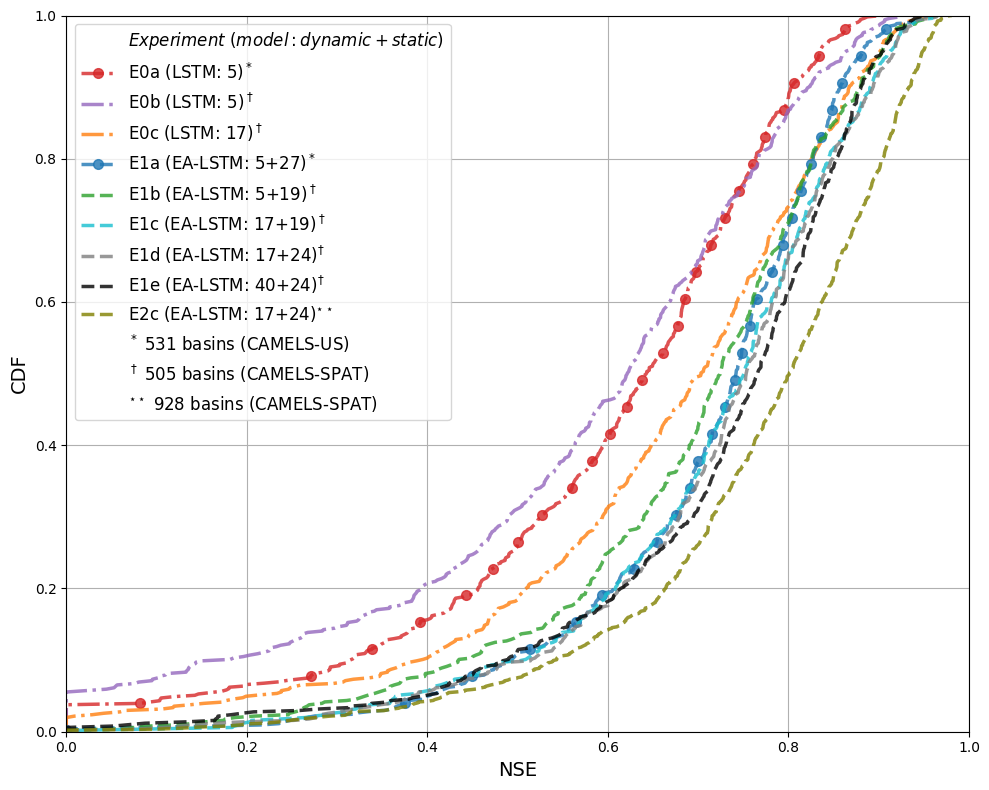

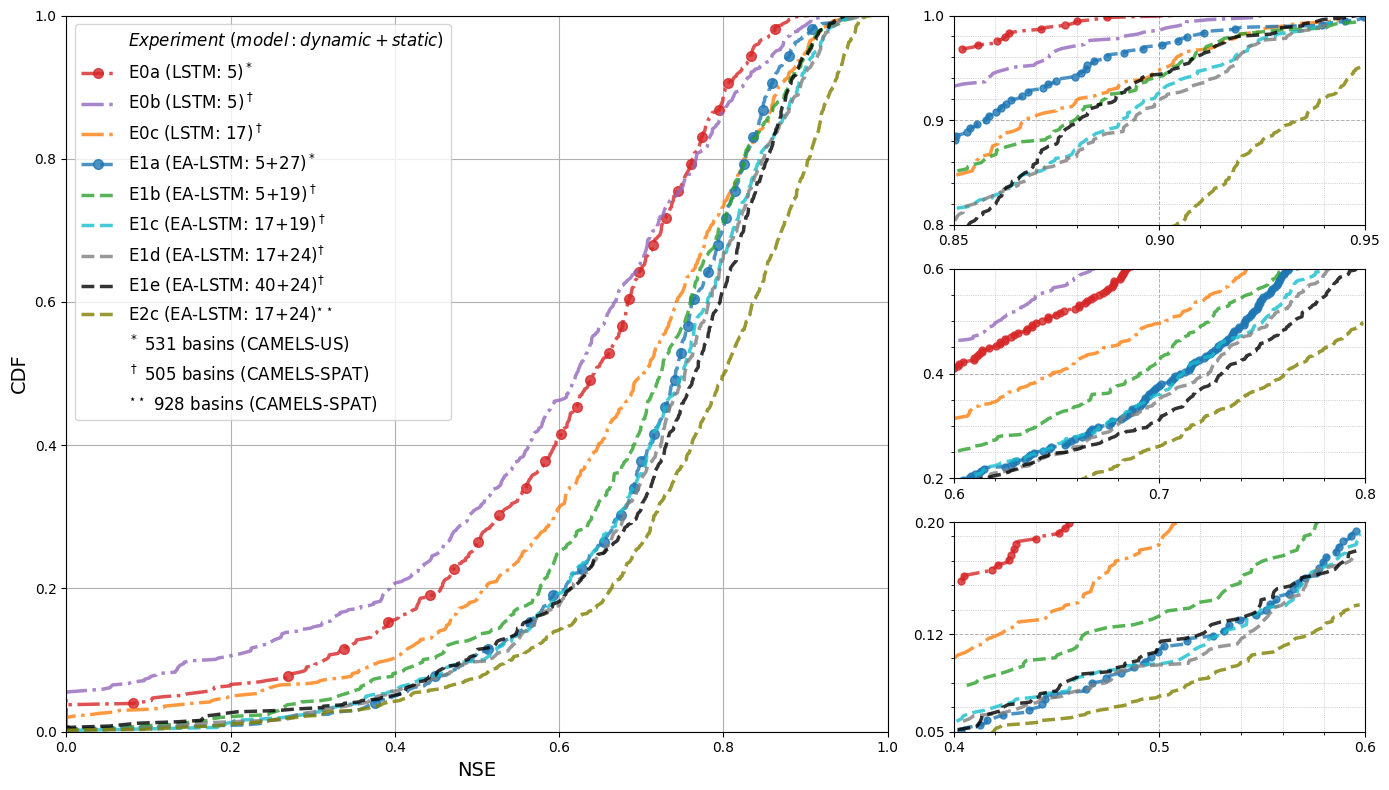

In [127]:
# Load config_file
with open('config_nh_run_plots.yml', 'r') as ymlfile:
        config_data2 = yaml.load(ymlfile, Loader=yaml.FullLoader)

folder4cdf_dir_list = config_data2['folders4cdf_dir']

# # Plot the CFD 
# plot_cdf_with_zoom(folder4cdf_dir_list)

# Define zoom ranges
zoom_ranges_x = [(0.85, 0.95), (0.6, 0.8), (0.4, 0.6)]
zoom_ranges_y = [(0.8, 1.0), (0.2, 0.6), (0.05, 0.2)]

# Call the function
plot_cdf_with_zoom(folder4cdf_dir_list, zoom_ranges_x, zoom_ranges_y)

### No zoom areas

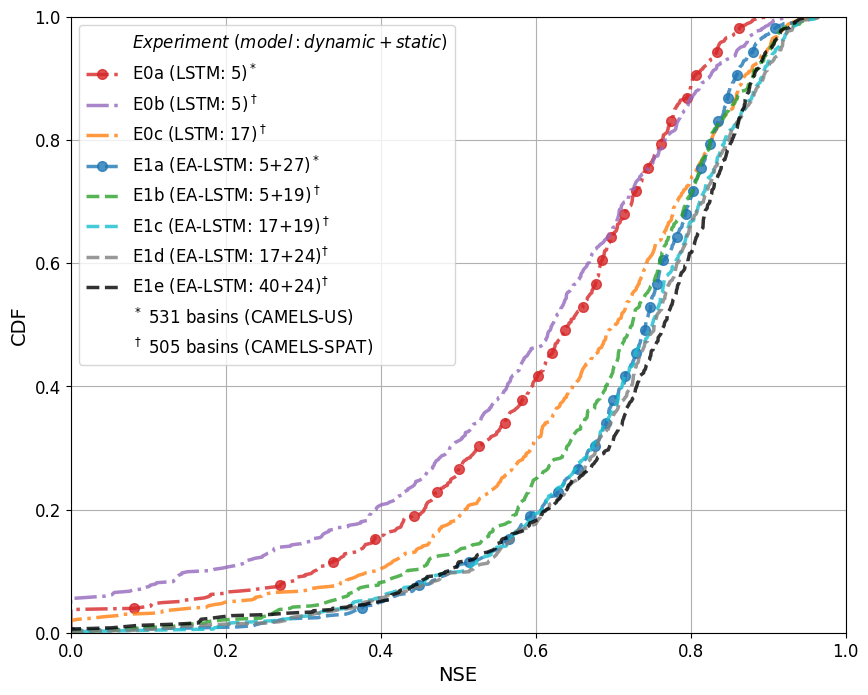

In [87]:
# Load config_file
with open('config_nh_run_plots.yml', 'r') as ymlfile:
        config_data2 = yaml.load(ymlfile, Loader=yaml.FullLoader)

folder4cdf_dir_list = config_data2['folders4cdf_dir']

plt.figure(figsize=(10, 8))

# Add an empty plot for the title in the legend
plt.plot([], [], ' ', label=r'$\it{Experiment\ (model: dynamic+static)}$')

for folder in folder4cdf_dir_list:
        
    folder_dir = Path(folder['directory'])
    folder_exp = folder['experiment']
    folder_color = folder['color']
    folder_marker = folder['marker']
    folder_line = folder['linestyle']

#     # Load the result dataframe
#     df = pd.read_csv(folder_dir / 'test_ensemble_metrics.csv')
    # See if test_ensemble_metrics.csv exists, if not, any other csv file
    if os.path.exists(folder_dir / 'test_ensemble_metrics.csv'):
        df = pd.read_csv(folder_dir / 'test_ensemble_metrics.csv')
    else:
        csv_files = [f for f in os.listdir(folder_dir) if f.endswith('.csv')]
        df = pd.read_csv(folder_dir / csv_files[0])

    # Make negative NSE values zero
    df['NSE'] = df['NSE'].apply(lambda x: 0 if x < 0 else x)

    # # Filter the result dataframe to only include the proper basins
    # df = filter_basins(df, 
    #                     filter_by_447=FILTER_BY_447, 
    #                     filter_by_505=FILTER_BY_505, 
    #                     filter_by_531=FILTER_BY_531)
    
    # Select basin and NSE columns
    df = df[['basin', 'NSE']].copy()
    # Sort NSE values
    nse_values = np.sort(df['NSE'])
    # Calculate cumulative probabilities
    cdf = np.arange(1, len(nse_values) + 1) / len(nse_values)
    # Plot the CDF
    plt.plot(nse_values, cdf, color=folder_color, 
             alpha=0.8,
             linewidth=2.5,
             marker=folder_marker, 
             markevery=20,
             ms=7,
             linestyle=folder_line, 
             label=folder_exp)
    
# Add an empty plot for the title in the legend
plt.plot([], [], ' ', label=r'$^*$ 531 basins (CAMELS-US)')
plt.plot([], [], ' ', label=r'$^\dagger$ 505 basins (CAMELS-SPAT)')
# plt.plot([], [], ' ', label=r'$^\diamond$ 928 basins (CAMELS-SPAT)')
# plt.plot([], [], ' ', label=r'$^\star$ 915 basins (CAMELS-SPAT)')

# Set the limits of the x and y axis to the range of the data
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('NSE', fontsize=14)
plt.ylabel('CDF', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)

# Save the plot
plt.savefig('cdf_nse.png', dpi=150, bbox_inches='tight')

plt.show()

### Zoom areas

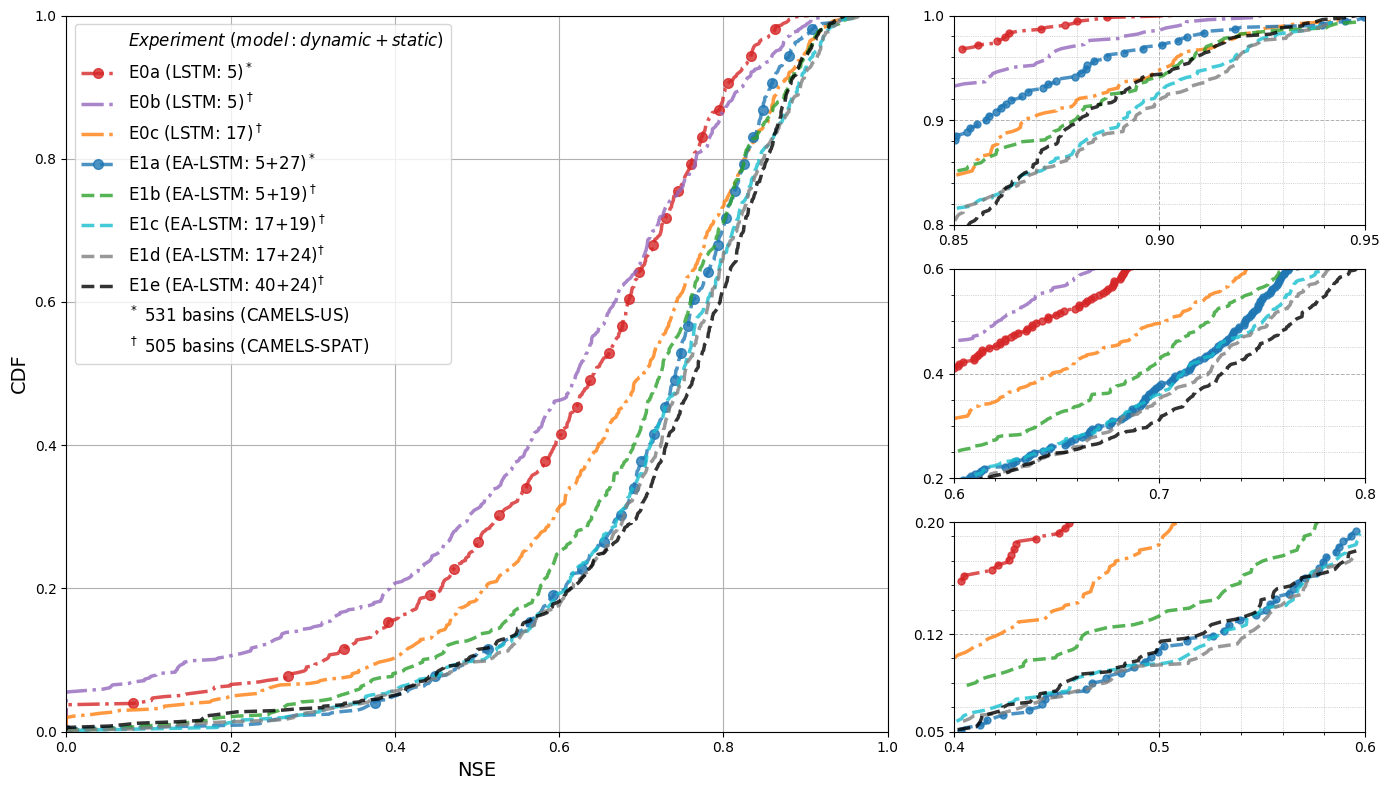

In [124]:
# Create main figure with a GridSpec for structured subplots
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(3, 2, width_ratios=[2, 1])  # Main plot spans two columns, three rows for zoomed plots

# Main plot on the left
ax_main = fig.add_subplot(gs[:, 0])  # This spans all rows on the left

# Zoomed-in plots on the right (stacked vertically)
ax_inset_top = fig.add_subplot(gs[0, 1])  # Top zoom
ax_inset_middle = fig.add_subplot(gs[1, 1])  # Middle zoom
ax_inset_bottom = fig.add_subplot(gs[2, 1])  # Bottom zoom

# List of axes for zoomed-in plots
inset_axes = [ax_inset_top, ax_inset_middle, ax_inset_bottom]

# Define zoom-in ranges for each inset
zoom_ranges_x = [
    (0.85, 0.95),  # NSE zoom range for the top inset
    (0.6, 0.8),  # NSE zoom range for the middle inset
    (0.4, 0.6)   # NSE zoom range for the bottom inset
]

zoom_ranges_y = [
    (0.8, 1.0),  # CDF zoom range for the top inset
    (0.2, 0.6),  # CDF zoom range for the middle inset
    (0.05, 0.2)   # CDF zoom range for the bottom inset
]

# Add an empty plot for the title in the legend
ax_main.plot([], [], ' ', label=r'$\it{Experiment\ (model: dynamic+static)}$')

# Main plot loop
for folder in folder4cdf_dir_list:
    folder_dir = Path(folder['directory'])
    folder_exp = folder['experiment']
    folder_color = folder['color']
    folder_marker = folder['marker']
    folder_line = folder['linestyle']

    # Load the result dataframe
    if os.path.exists(folder_dir / 'test_ensemble_metrics.csv'):
        df = pd.read_csv(folder_dir / 'test_ensemble_metrics.csv')
    else:
        csv_files = [f for f in os.listdir(folder_dir) if f.endswith('.csv')]
        df = pd.read_csv(folder_dir / csv_files[0])

    # Make negative NSE values zero
    df['NSE'] = df['NSE'].apply(lambda x: 0 if x < 0 else x)

    # Select basin and NSE columns
    df = df[['basin', 'NSE']].copy()
    # Sort NSE values
    nse_values = np.sort(df['NSE'])
    # Calculate cumulative probabilities
    cdf = np.arange(1, len(nse_values) + 1) / len(nse_values)

    # Plot the main CDF curve
    ax_main.plot(nse_values, cdf, color=folder_color,
                 alpha=0.8,
                 linewidth=2.5,
                 marker=folder_marker,
                 markevery=20,
                 ms=7,
                 linestyle=folder_line,
                 label=folder_exp)

    # Plot zoomed-in sections for each inset plot
    for ax_inset, zoom_range in zip(inset_axes, zoom_ranges_x):
        # Filter NSE values for the zoomed range
        cdf_inset = cdf[(nse_values >= zoom_range[0]) & (nse_values <= zoom_range[1])]
        nse_values_inset = nse_values[(nse_values >= zoom_range[0]) & (nse_values <= zoom_range[1])]

        # Plot on the respective inset
        ax_inset.plot(nse_values_inset, cdf_inset, color=folder_color,
                      alpha=0.8,
                      linewidth=2.5,
                      marker=folder_marker,
                      markevery=2,
                      ms=5,
                      linestyle=folder_line)
        
# Add an empty plot for the title in the legend
ax_main.plot([], [], ' ', label=r'$^*$ 531 basins (CAMELS-US)')
ax_main.plot([], [], ' ', label=r'$^\dagger$ 505 basins (CAMELS-SPAT)')

# Set labels and limits for the main plot
ax_main.set_xlim(0, 1)
ax_main.set_ylim(0, 1)
ax_main.set_xlabel('NSE', fontsize=14)
ax_main.set_ylabel('CDF', fontsize=14)
ax_main.grid(True)
ax_main.legend(fontsize=12)

# Customize each inset plot (zoomed-in subplots)
for ax_inset, zoom_range_x, zoom_range_y in zip(inset_axes, zoom_ranges_x, zoom_ranges_y):
    # Set the x and y limits based on the provided ranges
    ax_inset.set_xlim(zoom_range_x[0], zoom_range_x[1])
    ax_inset.set_ylim(zoom_range_y[0], zoom_range_y[1])
    
    # Set coarser grid spacing for X and Y ticks and round to 1 decimal place
    ax_inset.set_xticks(np.round(np.linspace(zoom_range_x[0], zoom_range_x[1], num=3), 2))  # 3 major ticks on X-axis
    ax_inset.set_yticks(np.round(np.linspace(zoom_range_y[0], zoom_range_y[1], num=3), 2))  # 3 major ticks on Y-axis
    
    # Set the grid with a coarser appearance
    ax_inset.grid(True, which='major', linestyle='--', linewidth=0.7)  # Coarser major grid

    # Optionally, make minor grid lines finer (if needed)
    ax_inset.minorticks_on()
    ax_inset.grid(True, which='minor', linestyle=':', linewidth=0.5)  # Minor grid as dotted lines

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('cdf_nse_zoomed.png', dpi=150, bbox_inches='tight')

plt.show()

## Metrics-Map

In [67]:
# # Plot histogram of NSE values
# plt.figure(figsize=(5, 4))
# plt.hist(result_df['nse'], bins=20, color='tab:blue', alpha=0.5)
# plt.xlabel('NSE')
# plt.ylabel('Frequency')
# plt.title('Histogram of NSE values')
# plt.show()

hist_values


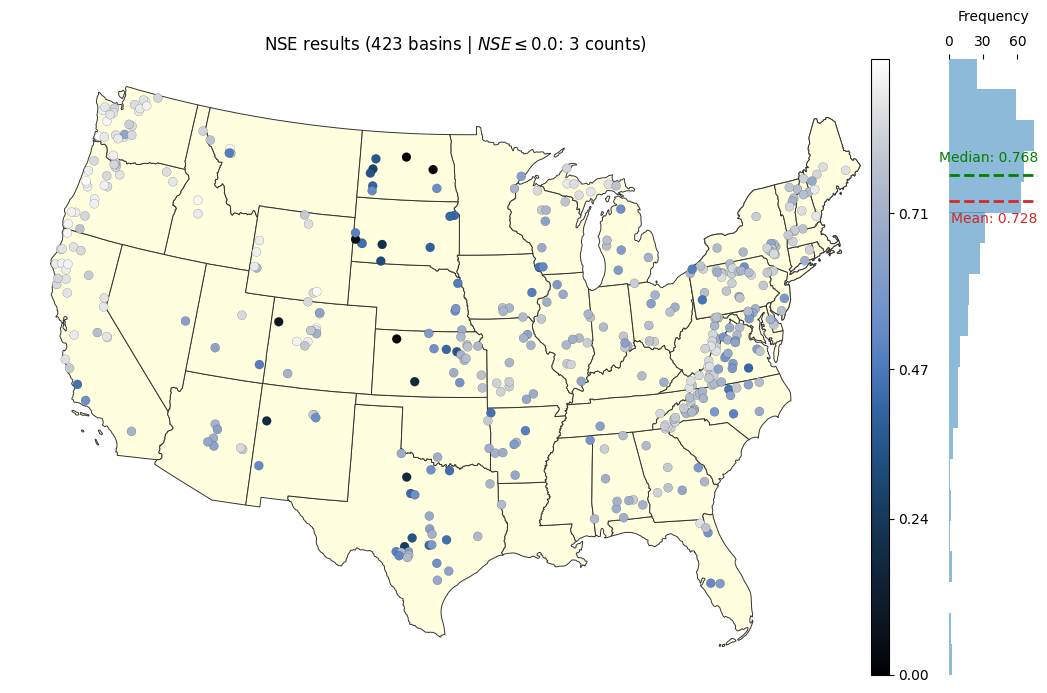

hist_values


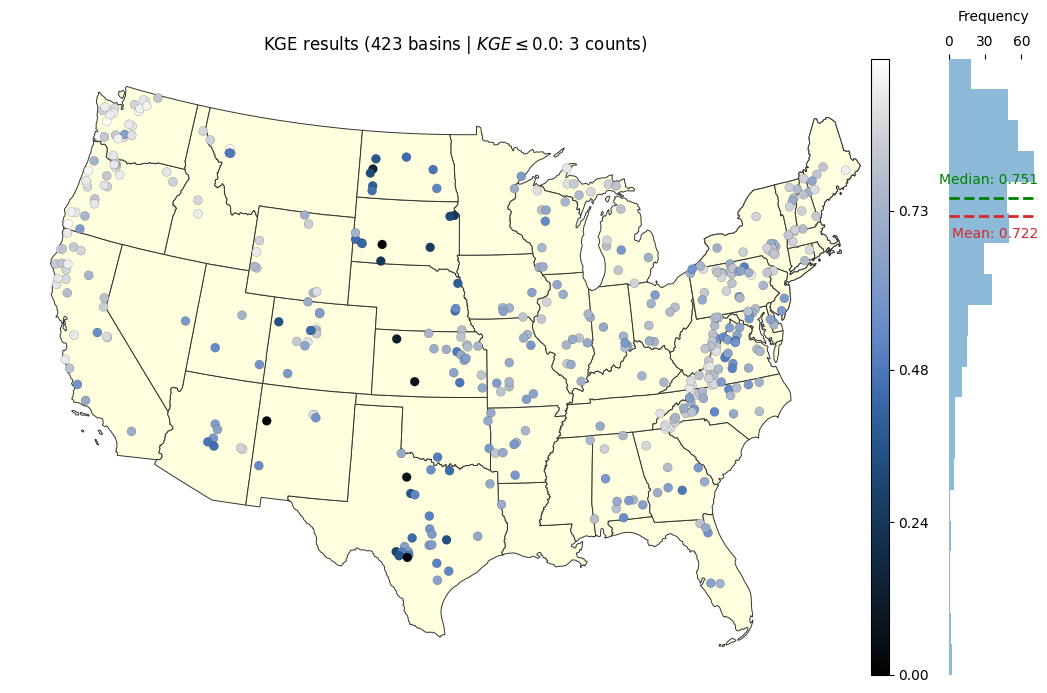

In [68]:
for metric in metrics4plotting:
    plot_metric_map(result_df, states_reprojected, hm_catchment_gdf_reprojected, 
                    basin_coordinates_reprojected, 
                    metric=metric, 
                    result_dir=result_dir,
                    thresholds=TRESHOLD_DICT)

# Tables

In [69]:
# Read the CSV files
data = {}
for file_name in config_data['files4table']:
    df = pd.read_csv(os.path.join(result_dir, file_name))

    # Filter the result dataframe to only include the proper basins
    data[file_name] = filter_basins(df, 
                                    filter_by_447=FILTER_BY_447, 
                                    filter_by_505=FILTER_BY_505, 
                                    filter_by_531=FILTER_BY_531)

    # print(f"Loaded {file_name} with {data[file_name].shape[0]} rows")
    # display(data[file_name].head())
    
# Initialize an empty dictionary to store statistics
statistics = {}

# Calculate statistics for each model
for file_name, df in data.items():
    
    # Lowercase the column names
    df.columns = df.columns.str.lower() 
    # '_' to '-' in column names
    df.columns = df.columns.str.replace('_', '-') 
    
    case_id = ('_').join(file_name.split('.')[0].split('_')[-2:])
    
    # If NSE is in the columns, count the number of basins with NSE < 0 and exclude those rows after
    if 'nse' in df.columns:
        n_basins_nse_lt_0 = df[df['nse'] <= 0].shape[0]
        # Set negative NSE values to 0
        df['nse'] = df['nse'].apply(lambda x: 0 if x < 0 else x)
        median = df['nse'].median()
        mean = df['nse'].mean()
        statistics[case_id] = {'nse': {
            'median': median,
            'mean': mean,
        }}
        statistics[case_id]['n_basins_nse_lt_0'] = n_basins_nse_lt_0
    
    # For each metric, find median- for NSE calculate mean, and number of basins with NSE < 0 (exclude those from all the statistics)
    for met in config_data['metrics4table']:
        
        met = met.lower()
        # Compute the statistics
        if met != 'nse':
            median = df[met].median()
            statistics[case_id][met] = {
                'median': median,
            }

# Create DataFrame from statistics dictionary
df_statistics = pd.DataFrame(statistics).transpose()

In [70]:
# Convert data to DataFrame
df_statistics = pd.DataFrame(statistics).T

# Convert nested dictionaries to individual columns
df_statistics['nse_mean'] = df_statistics['nse'].apply(lambda x: round(x['mean'], 3))
df_statistics['nse_median'] = df_statistics['nse'].apply(lambda x: round(x['median'], 3))
df_statistics['n_basins_nse_lt_0_count'] = df_statistics['n_basins_nse_lt_0']
df_statistics['alpha-nse_median'] = df_statistics['alpha-nse'].apply(lambda x: round(x['median'], 3))
df_statistics['beta-nse_median'] = df_statistics['beta-nse'].apply(lambda x: round(x['median'], 3))
df_statistics['fhv_median'] = df_statistics['fhv'].apply(lambda x: round(x['median'], 1))
df_statistics['fms_median'] = df_statistics['fms'].apply(lambda x: round(x['median'], 1))
df_statistics['flv_median'] = df_statistics['flv'].apply(lambda x: round(x['median'], 1))

# Drop unnecessary columns
df_statistics.drop(columns=['nse', 'n_basins_nse_lt_0', 'alpha-nse', 'beta-nse', 'fhv', 'fms', 'flv'], inplace=True)

# Ensure the 'n_basins_nse_lt_0_count' column is numeric
df_statistics['n_basins_nse_lt_0_count'] = pd.to_numeric(df_statistics['n_basins_nse_lt_0_count'])

# Ensure only numerical columns are selected for mean calculation
numeric_cols = df_statistics.select_dtypes(include=['float64', 'int']).columns

# Add a row for the mean values of the statistics
mean_values = df_statistics.loc[df_statistics.index != 'ensemble_metrics', numeric_cols].mean()
# Round the mean values to 3 decimal places
mean_values = mean_values.round(3)

# Create a new DataFrame for the mean values
df_mean = pd.DataFrame(mean_values).transpose()
df_mean.index = ['seeds_mean']

# Add the std values to the DataFrame
std_values = df_statistics.loc[df_statistics.index != 'ensemble_metrics', numeric_cols].std()
# Round the std values to 3 decimal places
std_values = std_values.round(3)

# Create a new DataFrame for the std values
df_std = pd.DataFrame(std_values).transpose()
df_std.index = ['seeds_std']

# Insert the mean row before the 'ensemble_metrics' row
idx = df_statistics.index.get_loc('ensemble_metrics')
df_statistics = pd.concat([df_statistics.iloc[:idx], df_mean, df_std, df_statistics.iloc[idx:]])

display(df_statistics)

# Convert DataFrame to LaTeX table format
latex_table = df_statistics.to_latex(
    index=True,
    header=True,
    float_format="%.3f"
)

print(latex_table)

,nse_mean,nse_median,n_basins_nse_lt_0_count,alpha-nse_median,beta-nse_median,fhv_median,fms_median,flv_median
111,0.697,0.744,3.000,0.896,0.010,-10.200,-9.600,5.200
222,0.697,0.742,2.000,0.895,0.008,-11.200,-10.900,4.300
333,0.697,0.743,4.000,0.902,0.015,-10.100,-10.600,-5.100
444,0.697,0.740,3.000,0.892,0.009,-11.000,-11.900,5.600
555,0.693,0.738,5.000,0.892,0.010,-10.600,-9.200,-2.200
666,0.698,0.740,5.000,0.881,0.011,-11.100,-9.700,-5.700
777,0.696,0.744,3.000,0.894,0.014,-10.300,-12.600,4.400
888,0.699,0.740,1.000,0.893,0.010,-10.000,-11.200,-3.000
seeds_mean,0.697,0.741,3.250,0.893,0.011,-10.562,-10.712,0.438
seeds_std,0.002,0.002,1.389,0.006,0.002,0.481,1.184,4.885


\begin{tabular}{lrrrrrrrr}
\toprule
 & nse_mean & nse_median & n_basins_nse_lt_0_count & alpha-nse_median & beta-nse_median & fhv_median & fms_median & flv_median \\
\midrule
111 & 0.697 & 0.744 & 3.000 & 0.896 & 0.010 & -10.200 & -9.600 & 5.200 \\
222 & 0.697 & 0.742 & 2.000 & 0.895 & 0.008 & -11.200 & -10.900 & 4.300 \\
333 & 0.697 & 0.743 & 4.000 & 0.902 & 0.015 & -10.100 & -10.600 & -5.100 \\
444 & 0.697 & 0.740 & 3.000 & 0.892 & 0.009 & -11.000 & -11.900 & 5.600 \\
555 & 0.693 & 0.738 & 5.000 & 0.892 & 0.010 & -10.600 & -9.200 & -2.200 \\
666 & 0.698 & 0.740 & 5.000 & 0.881 & 0.011 & -11.100 & -9.700 & -5.700 \\
777 & 0.696 & 0.744 & 3.000 & 0.894 & 0.014 & -10.300 & -12.600 & 4.400 \\
888 & 0.699 & 0.740 & 1.000 & 0.893 & 0.010 & -10.000 & -11.200 & -3.000 \\
seeds_mean & 0.697 & 0.741 & 3.250 & 0.893 & 0.011 & -10.562 & -10.712 & 0.438 \\
seeds_std & 0.002 & 0.002 & 1.389 & 0.006 & 0.002 & 0.481 & 1.184 & 4.885 \\
ensemble_metrics & 0.728 & 0.768 & 3.000 & 0.871 & 0.012 & -12.20